# Lane detection

In our previous implementation of lane detection using the Hough method we noticed some issues:
+ The model would only work in perfect conditions and would not consistent, failing and crashing in some images
+ The model could not detect curves accurately
+ The model was not very robust to shadows and obstructions, if lanes were not present the model would crash entirely

In this notebook we provide a different approach using a **sliding window algorithm** to detect lanes and a **perspective transformation** in order to have a top view of the image allowing us to fit a pollynomial to the lane line.

Our pipeline would be as follows:
+ Perspective transformation to get top view of image
+ Canny edge detector using a sobel filter to detect saturation and lightness of the image
+ Histogram Peak detection to detect intensity peaks in filtered image, indicating lanes
+ Sliding window search
+ Curve fitting, lane detection

In [5]:
# Import packages
import os
import cv2 as cv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [25]:
IMG_SIZE = (1280,720)

## Perspective Transform

By transforming the perspective of the image to a top view we can now assume the lane to be in a flat 2D surface and so, we can **fit a polynomial that can represent the lane**

To do that we will use the ``` cv.getPerspectiveTransform()``` to get the transformation matrix and ``` cv.warpPerspective()``` to apply that transformation to the image

In [69]:
def perspectiveTransformation(img, 
                     dst_size=(1280,720),
                     src=np.float32([(0.3,0.65),(0.9,0.65),(0.1,1),(1,1)]),
                     dst=np.float32([(0,0), (1, 0), (0,1), (1,1)])):
    img_size = np.float32([(img.shape[1],img.shape[0])])
    src = src* img_size
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    # again, not exact, but close enough for our purposes
    dst = dst * np.float32(dst_size)
    # Given src and dst points, calculate the perspective transform matrix
    M = cv.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv.warpPerspective(img, M, dst_size)
    return warped

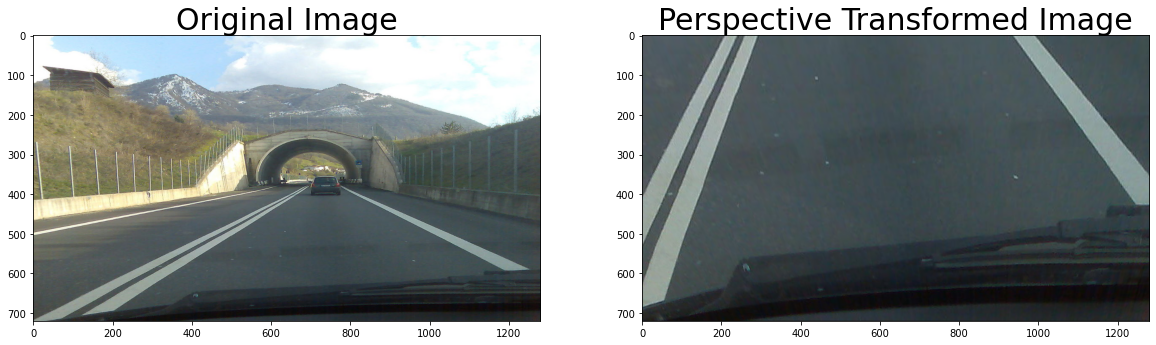

In [77]:
# Example of perspective transformation
img = cv.imread('lane.jpg')
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img = cv.resize(img,(1280,720))
persp_out = perspectiveTransformation(img, dst_size=(1280,720))

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Original Image', fontsize=30)
ax1.imshow(img)

ax2.set_title('Perspective Transformed Image',fontsize=30)
ax2.imshow(persp_out)


## Sobel filtering

Now that we have a better view of the lanes we can apply the sobel filter to extract the saturation and lightness gradients on the x axis and save the pixels that pass throught the gradient threshold

In [ ]:
def edgeFilter(img,s_thresh=(100, 255), sx_thresh=(15, 255)):
    img = np.copy(img)
    
    #Convert img to HLS space
    hls = cv.cvtColor(img,cv.COLOR_RGB2HLS).astype(np.float)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    #Sobel on x axis
    sobel = cv.Sobel(l_channel,cv.CV_64F,1,1)
    abs_sobel = np.absolute(sobel)
    normalized_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    #Threshold gradient
    